In [1]:
%load_ext autoreload
%autoreload 2

In [97]:
from autoplan.token import OCamlTokenizer
from autoplan.trainer import ClassifierTrainer, option_combinations
from autoplan.vis import plot_accuracy, plot_cm, plot_loss
from autoplan.dataset import TrainVal, build_synthetic_dataset, set_random_seed, concat_datasets
from autoplan.generator import ProgramGenerator
from autoplan.neighbors import TokenNNClassifier, TreeNNClassifier


from grammars.rainfall.ocaml import Program, Labels

from tqdm.auto import tqdm
from torch.utils.data import ConcatDataset, Subset
from scripts.rainfall_ingest import ingest_dataset, load_new_labels
import torch
import seaborn as sns
from iterextras import par_for
from pickle_cache import PickleCache
from torch import nn
import numpy as np
import dataclasses

pcache = PickleCache()
device = torch.device('cuda:7')

In [3]:
known_student_dataset = ingest_dataset('T1')
unknown_student_dataset = load_new_labels(known_student_dataset.vocab_index)

Skipped 16 programs


In [148]:
for item in unknown_student_dataset.dataset:
    if item['labels'].item() == 0:
        print(item['source'])
        print('='*30)

let rec help (alon : float list) =
  (match alon with
   | [] -> []
   | hd::tl ->
       if hd = (-999.)
       then []
       else if hd >= 0. then hd :: (help tl) else help tl : float list)
let rec rainfall (alon : float list) =
  (match alon with
   | [] -> failwith "no proper rainfall amounts"
   | _::_ ->
       (List.fold_right (+.) (help alon) 0.) /.
         (float_of_int (List.length (help alon))) : float)

let rec _rainfall (alon : int list) =
  (match alon with
   | [] -> []
   | (-999)::tl -> []
   | hd::tl -> if hd >= 0 then hd :: (_rainfall tl) else _rainfall tl : 
  int list)
let rainfall (alon : int list) =
  (match alon with
   | [] -> 0
   | hd::tl ->
       (List.fold_right (+) (_rainfall alon) 0) /
         (List.length (_rainfall alon)) : int)

let rainfall (alon : int list) =
  (let rec rainfall_helper (alon : int list) =
     (match alon with
      | [] -> []
      | hd::tl -> if hd = (-999) then [] else hd :: (rainfall_helper tl) : 
     int list) in
   List.fo

In [9]:
N = 1000
K = 1

def build(i):
    set_random_seed(i)
    return build_synthetic_dataset(
        label_set=Labels, 
        N=N, 
        tokenizer=OCamlTokenizer(), 
        generator=ProgramGenerator(Program()),
        vocab_index=known_student_dataset.vocab_index,
        unique=True)

synthetic_datasets = [build(0)] #par_for(build, range(K), process=False, workers=1)
synthetic_dataset = synthetic_datasets[0]
synth_small_dataset = synthetic_dataset.subset(200)

In [6]:
def resample(N):
    all_idxs = []
    for lbl in synthetic_dataset.label_set:
        idxs = [i for i, item in enumerate(synthetic_dataset.dataset) if item['labels'].item() == int(lbl)]
        all_idxs.extend(np.random.choice(idxs, N))
    return dataclasses.replace(synthetic_dataset, dataset=Subset(synthetic_dataset.dataset, all_idxs))

synthetic_balance = resample(120)

In [94]:
model_opts = {
    'model': nn.LSTM,
    'hidden_size': 2048,
    'embedding_size': 128
}

combined_synth_student = concat_datasets(known_student_dataset, synthetic_dataset)
combined_synthsmall_student = concat_datasets(known_student_dataset, synth_small_dataset)

def train(train_dataset, lr, model_opts, epochs=100):
    set_random_seed(0)

    trainer = ClassifierTrainer(
        dataset=train_dataset,
        device=device, 
        split=TrainVal(
            dataset=train_dataset, val_dataset=known_student_dataset), 
        model_opts=model_opts,
        optim_opts={'lr': lr})

    losses = []
    train_eval = []
    known_val_eval = []
    unknown_val_eval = []

    for _ in tqdm(range(epochs)):
        loss = trainer.train_one_epoch()
        losses.append(loss)
        train, val = trainer.eval()
        train_eval.append(train)
        known_val_eval.append(val)
        trainer.model.eval()
        unknown_val_eval.append(trainer.eval_on(unknown_student_dataset.loader(unknown_student_dataset.dataset)))
        trainer.model.train()
    
    return losses, train_eval, known_val_eval, unknown_val_eval

In [401]:
losses, train_eval, known_student_eval, unknown_student_eval = train(
    known_student_dataset, lr=1e-4, model_opts=model_opts)

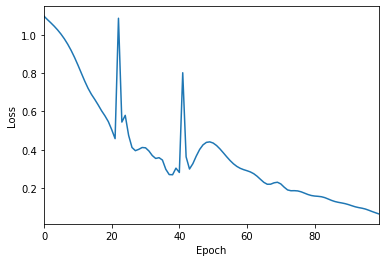

In [402]:
plot_loss(losses)

Max unk acc:  0.8791208791208791


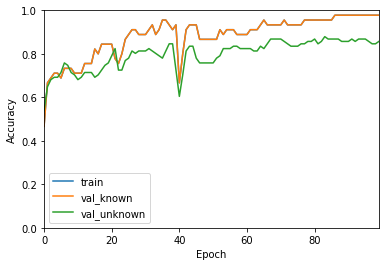

In [403]:
ax = plot_accuracy(train_eval, label='train')
plot_accuracy(known_student_eval, ax=ax, label='val_known')
plot_accuracy(unknown_student_eval, ax=ax, label='val_unknown')
ax.legend()
print('Max unk acc: ', max([evl.accuracy for evl in unknown_student_eval]))

In [409]:
model_options = [
    ('model', [nn.GRU, nn.LSTM]),
    ('hidden_size', [32, 128, 512, 2048]),
    ('embedding_size', [32, 128, 512, 2048]),
]

all_synth_results = [
    train(synthetic_dataset, model_opts=opts, lr=3e-5, epochs=50)
    for opts in tqdm(option_combinations(model_options))
]

KeyboardInterrupt: 

In [ ]:
sorted([
    (opts, max([evl.accuracy for evl in res[3]]))
    for opts, res in zip(option_combinations(model_options), all_synth_results)
], key=lambda t: -t[1])

In [21]:
losses, train_eval, known_student_eval, unknown_student_eval = train(
    synthetic_dataset, lr=3e-5, model_opts=model_opts, epochs=50)

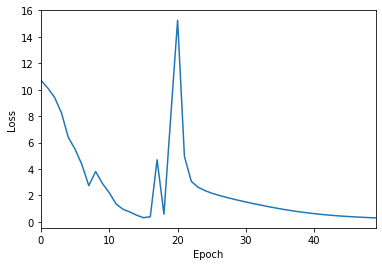

In [22]:
plot_loss(losses)

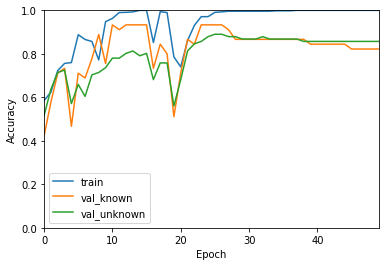

In [23]:
ax = plot_accuracy(train_eval, label='train')
plot_accuracy(known_student_eval, ax=ax, label='val_known')
plot_accuracy(unknown_student_eval, ax=ax, label='val_unknown')
ax.legend()

Overall accuracy: 0.933


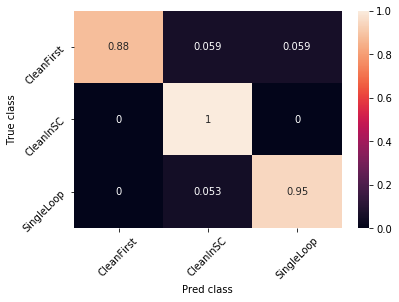

In [24]:
best_known_eval = known_student_eval[np.argmax([evl.accuracy for evl in known_student_eval])]
print('Overall accuracy: {:.3f}'.format(best_known_eval.accuracy))
best_known_eval.plot_cm('')

Overall accuracy: 0.890


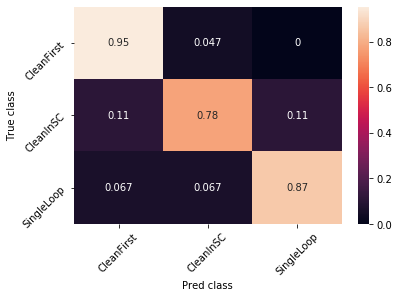

In [25]:
best_unknown_eval = unknown_student_eval[np.argmax([evl.accuracy for evl in unknown_student_eval])]
print('Overall accuracy: {:.3f}'.format(best_unknown_eval.accuracy))
best_unknown_eval.plot_cm('')

In [323]:
for idx in best_unknown_eval.incorrect():
    item = unknown_student_dataset.dataset[idx]
    print(item['source'])
    print('True: ', Labels(best_unknown_eval.true[idx]))
    print('Pred: ', Labels(best_unknown_eval.pred[idx]))
    print('='*30 + '\n\n')

let average_rainfall (alon : int list) =
  (let rainsum =
     List.fold_right
       (fun el ->
          fun next ->
            if el = (-999) then 0 else if el < 0 then next else el + next)
       alon 0
   and data =
     List.length
       (List.fold_right
          (fun el ->
             fun next ->
               if el = (-999)
               then []
               else if el < 0 then next else el :: next) alon []) in
   if data = 0 then 0 else rainsum / data : int)

True:  GeneralRainfallLabels.CleanInSC
Pred:  GeneralRainfallLabels.SingleLoop


let rec rainfall (alon : int list) =
  (let rec takewhile (alonh : int list) =
     (match alonh with
      | [] -> []
      | hd::tl -> if not (hd = (-999)) then hd :: (takewhile tl) else [] : 
     int list) in
   let length = List.length (List.filter (fun x -> x >= 0) (takewhile alon)) in
   match length with
   | 0 -> failwith "division by zero."
   | _ ->
       (List.fold_right (+) (List.filter (fun x -> x >= 0) (takewhile alon)

In [14]:
import nltk

def compute_dist(student_item):
    return [
        nltk.edit_distance(student_item['program'], synth_item['program'])
        for j, synth_item in tqdm(enumerate(synthetic_dataset.dataset))
    ]

dists = par_for(compute_dist, unknown_student_dataset.dataset, process=True)

In [16]:
dist_matrix = np.vstack([np.array(l) for l in dists])

In [56]:
all_mins = np.percentile(dist_matrix, 25, axis=1)

incor_mins = np.percentile(dist_matrix[best_unknown_eval.incorrect(), :], 25, axis=1)

In [61]:
ds = synthetic_dataset.dataset
N = len(ds)
plan_idxs = [
    [j for j in range(N) if ds[j]['labels'].item() == i]
    for i in range(3)
]

for i in best_unknown_eval.incorrect():
    item = unknown_student_dataset.dataset[i]
    print(item['labels'].item())
    for j in range(3):
        print(j, np.mean(dist_matrix[i, plan_idxs[j]]))
    print('='*30)
    

1
0 76.0982800982801
1 61.06467661691542
2 69.25255102040816
1
0 77.41523341523342
1 77.92039800995025
2 79.27806122448979
1
0 104.004914004914
1 89.95522388059702
2 100.16326530612245
2
0 83.37837837837837
1 74.34328358208955
2 63.79081632653061
1
0 72.18181818181819
1 63.69651741293532
2 66.86479591836735
0
0 154.3857493857494
1 153.0497512437811
2 161.46173469387756
2
0 73.64127764127764
1 73.48756218905473
2 57.47959183673469
2
0 95.42506142506143
1 101.5273631840796
2 104.99489795918367
0
0 66.28501228501229
1 73.29353233830845
2 68.67857142857143
2
0 82.14250614250614
1 80.1044776119403
2 68.6734693877551


In [66]:
clf = TokenNNClassifier(synthetic_dataset, OCamlTokenizer())

In [74]:
programs, _ = clf.compute_programs(unknown_student_dataset)
dists = clf.compute_distance_matrix(programs)

In [131]:
clf.eval(unknown_student_dataset, dists, k=10).accuracy

0.8021978021978022

In [104]:
clf_tree = TreeNNClassifier(synthetic_dataset, OCamlTokenizer())

In [105]:
len(clf_tree.programs)

1000

In [106]:
programs_tree, filtered_ds_tree = clf_tree.compute_programs(unknown_student_dataset)


In [108]:
dists_tree = clf_tree.compute_distance_matrix(programs_tree)

In [141]:
max([clf_tree.eval(unknown_student_dataset, dists_tree, k=k).accuracy for k in range(1, 200, 5)])

0.8901098901098901

In [132]:
clf_tree_small = TreeNNClassifier(known_student_dataset, OCamlTokenizer())

In [133]:
dists_tree_small = clf_tree_small.compute_distance_matrix(programs_tree)

In [147]:
clf_tree_small.eval(unknown_student_dataset, dists_tree_small, k=10).accuracy

0.9340659340659341